# Data Loading

In [1]:
import pandas as pd

data = pd.read_csv('https://raw.githubusercontent.com/Ragnarok540/pdg/main/tags.txt', sep='~', header=None)
data.columns = ['links', 'req']
data.head()

,links,req
0,198,The solution should provide detailed context s...
1,282,The solution should provide an interface for t...
2,34,"The solution should send alerts (for example, ..."
3,8,The solution should enable the user to track t...
4,401597,The solution should enable the help desk user ...


# Data Labeling

In [2]:
import sys
from sklearn.preprocessing import LabelBinarizer

def add_categories(df):
  bins = [0, 11, 120, sys.maxsize]
  labels = ['low', 'moderate', 'high']
  category = pd.cut(df['links'], bins=bins, labels=labels)
  df['category'] = category
  lbin = LabelBinarizer()
  lbin.fit(labels)
  bin = pd.DataFrame.from_records(lbin.transform(df['category']), columns=lbin.classes_)
  return pd.concat([df, bin], axis='columns')

data = add_categories(data)

data.head()

,links,req,category,high,low,moderate
0,198,The solution should provide detailed context s...,high,1,0,0
1,282,The solution should provide an interface for t...,high,1,0,0
2,34,"The solution should send alerts (for example, ...",moderate,0,0,1
3,8,The solution should enable the user to track t...,low,0,1,0
4,401597,The solution should enable the help desk user ...,high,1,0,0


# Train-Test Split

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['req'], data[['low', 'moderate', 'high']], test_size=0.2, random_state=1)

# Data Transformation

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=7000)
tokenizer.fit_on_texts(data['req'])

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [5]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

glove = True

if glove:
  embedding_dim = 100
  embedding_matrix = create_embedding_matrix(
      '/content/drive/MyDrive/cnn/glove.6B.100d.txt',
      tokenizer.word_index, embedding_dim)
else:
  embedding_dim = 100
  embedding_matrix = create_embedding_matrix(
      '/content/drive/MyDrive/cnn/word2vec.wiki.100d.txt',
      tokenizer.word_index, embedding_dim)

nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))

nonzero_elements / vocab_size

0.9328323156411461

# Model

In [7]:
from keras.models import Sequential
from keras import layers
from keras.metrics import Precision, Recall, CategoricalAccuracy

## Convolutional Neural Network

In [8]:
def model_cnn():
  model = Sequential()
  model.add(layers.Embedding(vocab_size, embedding_dim, 
                            weights=[embedding_matrix], 
                            input_length=maxlen,
                            mask_zero=True,
                            trainable=True))
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(16, 7, padding="valid", activation="relu", strides=3)) 
  model.add(layers.Conv1D(32, 7, padding="valid", activation="relu", strides=3)) 
  model.add(layers.GlobalMaxPooling1D())
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(3, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='adam', 
                metrics=[CategoricalAccuracy(), Precision(), Recall()])
  return model

## Recurrent Neural Network

In [9]:
def model_rnn():
  model = Sequential()
  model.add(layers.Embedding(vocab_size, embedding_dim, 
                             weights=[embedding_matrix], 
                             input_length=maxlen,
                             mask_zero=True,
                             trainable=True))
  model.add(layers.Dropout(0.3))
  model.add(layers.SimpleRNN(75, return_sequences=True))
  model.add(layers.GlobalMaxPooling1D())
  model.add(layers.Dense(75, activation='relu'))
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(3, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='Adam', 
                metrics=[CategoricalAccuracy(), Precision(), Recall()])
  return model

## LSTM Neural Network

In [10]:
def model_lstm():
  model = Sequential()
  model.add(layers.Embedding(vocab_size, embedding_dim, 
                             weights=[embedding_matrix], 
                             input_length=maxlen,
                             mask_zero=True,
                             trainable=True))
  model.add(layers.LSTM(50, return_sequences=True))
  model.add(layers.GlobalMaxPooling1D())
  model.add(layers.Dense(50, activation='relu'))
  model.add(layers.Dense(3, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='Adam', 
                metrics=[CategoricalAccuracy(), Precision(), Recall()])
  return model

## Bidirectional LSTM Neural Network

In [11]:
def model_bidirectional_lstm():
  model = Sequential()
  model.add(layers.Embedding(vocab_size, embedding_dim, 
                             weights=[embedding_matrix], 
                             input_length=maxlen,
                             mask_zero=True,
                             trainable=True))
  model.add(layers.Dropout(0.5))
  model.add(layers.Bidirectional(layers.LSTM(100, return_sequences=True)))
  model.add(layers.GlobalMaxPooling1D())
  model.add(layers.Dense(100, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(3, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='Adam', 
                metrics=[CategoricalAccuracy(), Precision(), Recall()])
  return model

## GRU Neural Network

In [12]:
def model_gru():
  model = Sequential()
  model.add(layers.Embedding(vocab_size, embedding_dim, 
                             weights=[embedding_matrix], 
                             input_length=maxlen,
                             mask_zero=True,
                             trainable=True))
  model.add(layers.Dropout(0.5))
  model.add(layers.GRU(50, return_sequences=True))
  model.add(layers.GlobalMaxPooling1D())
  model.add(layers.Dense(50, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(3, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='Adam', 
                metrics=[CategoricalAccuracy(), Precision(), Recall()])
  return model

## Transformer

In [13]:
# https://keras.io/examples/nlp/text_classification_with_transformer/

import tensorflow as tf

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, embedding_matrix):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, weights=[embedding_matrix])
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [14]:
def model_transformer():
  model = Sequential()
  model.add(layers.InputLayer(input_shape=(maxlen,)))
  model.add(TokenAndPositionEmbedding(maxlen=maxlen, vocab_size=vocab_size, embed_dim=embedding_dim, embedding_matrix=embedding_matrix))
  model.add(TransformerBlock(embed_dim=embedding_dim, num_heads=1, ff_dim=75))
  model.add(TransformerBlock(embed_dim=embedding_dim, num_heads=1, ff_dim=75))
  model.add(layers.GlobalAveragePooling1D())
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(75, activation='relu'))
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(3, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='Adam', 
                metrics=[CategoricalAccuracy(), Precision(), Recall()])
  return model

# Run Model

In [15]:
from keras.backend import clear_session

clear_session()

In [16]:
#model = model_cnn()
#model = model_rnn()
model = model_lstm()
#model = model_bidirectional_lstm()
#model = model_gru()
#model = model_transformer()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          638700    
_________________________________________________________________
lstm (LSTM)                  (None, 100, 50)           30200     
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                2550      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 153       
Total params: 671,603
Trainable params: 671,603
Non-trainable params: 0
_________________________________________________________________


In [17]:
from keras import callbacks

earlystopping = callbacks.EarlyStopping(monitor="val_recall", 
                                        mode="max", patience=5, 
                                        restore_best_weights=True,
                                        verbose=1)

history = model.fit(X_train, y_train,
                    epochs=100,
                    validation_data=(X_test, y_test),
                    batch_size=32,
                    shuffle=True,
                    callbacks=[earlystopping])

Epoch 1/100
133/133 [==============================] - 34s 97ms/step - loss: 1.0386 - categorical_accuracy: 0.4342 - precision: 0.4310 - recall: 0.0732 - val_loss: 0.7656 - val_categorical_accuracy: 0.6327 - val_precision: 0.6778 - val_recall: 0.5345
Epoch 2/100
133/133 [==============================] - 11s 83ms/step - loss: 0.7411 - categorical_accuracy: 0.6597 - precision: 0.6922 - recall: 0.5721 - val_loss: 0.7210 - val_categorical_accuracy: 0.6676 - val_precision: 0.6910 - val_recall: 0.6251
Epoch 3/100
133/133 [==============================] - 11s 82ms/step - loss: 0.6543 - categorical_accuracy: 0.6967 - precision: 0.7094 - recall: 0.6645 - val_loss: 0.6717 - val_categorical_accuracy: 0.6893 - val_precision: 0.7082 - val_recall: 0.6714
Epoch 4/100
133/133 [==============================] - 11s 83ms/step - loss: 0.5255 - categorical_accuracy: 0.7861 - precision: 0.7980 - recall: 0.7716 - val_loss: 0.7076 - val_categorical_accuracy: 0.6818 - val_precision: 0.6883 - val_recall: 0.6

# Evaluation

In [18]:
loss, accuracy, precision, recall = model.evaluate(X_train, y_train)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy, precision, recall = model.evaluate(X_test, y_test)
print("Testing Accuracy:  {:.4f}".format(accuracy))

133/133 [==============================] - 2s 17ms/step - loss: 0.3286 - categorical_accuracy: 0.8863 - precision: 0.8892 - recall: 0.8833
Training Accuracy: 0.8863
34/34 [==============================] - 1s 18ms/step - loss: 0.7419 - categorical_accuracy: 0.6931 - precision: 0.6977 - recall: 0.6865
Testing Accuracy:  0.6931


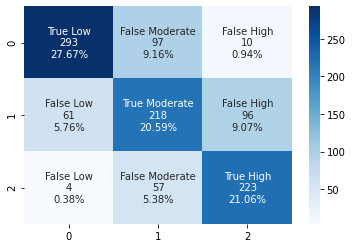

In [19]:
y_pred = model.predict(X_test)

import seaborn as sns

def cf_matrix_plot(cf_matrix):
  group_names = ['True Low', 'False Moderate', 'False High', 'False Low', 'True Moderate', 'False High', 'False Low', 'False Moderate', 'True High']
  group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
  labels = np.asarray(labels).reshape(3, 3)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

from sklearn import metrics

cf_matrix = metrics.confusion_matrix(y_test.to_numpy().argmax(axis=1), y_pred.argmax(axis=1))

cf_matrix_plot(cf_matrix)

In [20]:
print(metrics.classification_report(y_test.to_numpy().argmax(axis=1), y_pred.argmax(axis=1), labels=[0, 1, 2]))

              precision    recall  f1-score   support

           0       0.82      0.73      0.77       400
           1       0.59      0.58      0.58       375
           2       0.68      0.79      0.73       284

    accuracy                           0.69      1059
   macro avg       0.69      0.70      0.69      1059
weighted avg       0.70      0.69      0.69      1059



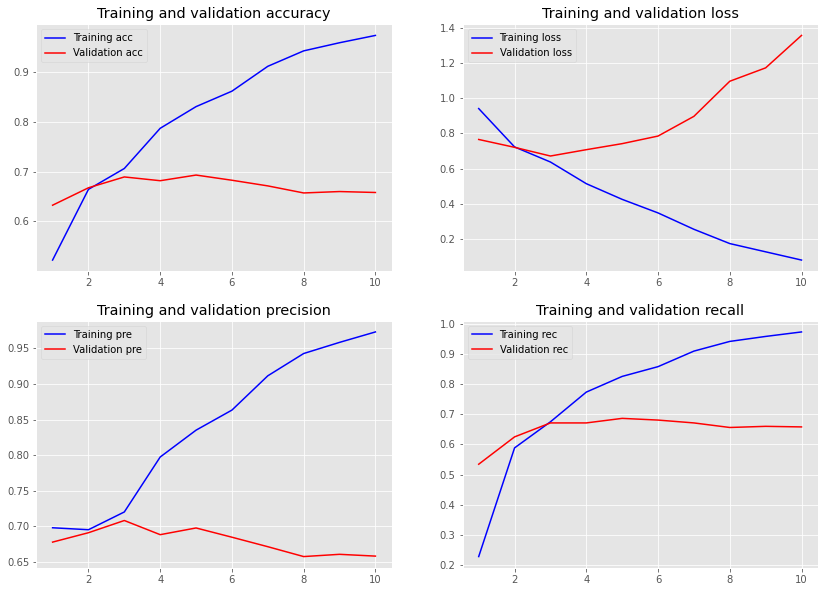

In [21]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    pre = history.history['precision']
    val_pre = history.history['val_precision']
    rec = history.history['recall']
    val_rec = history.history['val_recall']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 10))
    plt.subplot(2, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(2, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.subplot(2, 2, 3)
    plt.plot(x, pre, 'b', label='Training pre')
    plt.plot(x, val_pre, 'r', label='Validation pre')
    plt.title('Training and validation precision')
    plt.legend()
    plt.subplot(2, 2, 4)
    plt.plot(x, rec, 'b', label='Training rec')
    plt.plot(x, val_rec, 'r', label='Validation rec')
    plt.title('Training and validation recall')
    plt.legend()

plot_history(history)